In [47]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from utils.HexClasses import HEX, Fluid
from scipy.optimize import fsolve
from pathlib import Path

In [48]:
# initialise HEX
hex = HEX(L=6.1, ri=22.9e-3, ro=25.4e-3, R=50e-3, n=1)

# initialise fluids
fluid1 = Fluid(m=0.3, Cp=2916, rho=680, Ti=523, k=0.12, mu=4e-6 * 680)
fluid2 = Fluid(m=0.5, Cp=4180, rho=1000, Ti=603, k=0.6, mu=8.9e-4)
    
'''
f_type: 0 - parallel, 1 - counter
    mode: cinlet/rinlet: constant or random inlet
'''
f_type = 0
mode = "cinlet"
d_path = Path(f"../../py_data/HEXPractice/lumpHEX/{mode}")

if f_type == 0:
    dfs = pd.read_csv(f"{d_path}/parallel.csv", header=0)
elif f_type == 1:
    dfs = pd.read_csv(f"{d_path}/counter.csv", header=0)
    
T1i = dfs["F1i"]       # Fluid1 (cold) inlet temperature
T1o = dfs["F1o"]       # Fluid1 (cold) outlet temperature
m1 = dfs["F1m"]        # Fluid1 (cold) mass flow rate
T2i = dfs["F2i"]       # Fluid2 (hot) inlet temperature
T2o = dfs["F2o"]       # Fluid2 (hot) outlet temperature
m2 = dfs["F2m"]        # Fluid2 (hot) mass flow rate
dp1 = dfs["dP1"]       # Fluid1 (cold) pressure drop

fluid1.get_Inlets(T1i, m1)
fluid2.get_Inlets(T2i, m2)
fluid2.get_Prams(hex.Ac2, hex.D2, hex.As2)

In [49]:
# heat duty Q = m1 * Cp1 * (T1o - T1i)
Q = m1 * fluid1.Cp * (T1o - T1i)

# get log mean temperature difference
if f_type == 0:
    dT1 = T2i - T1i
    dT2 = T2o - T1o
elif f_type == 1:
    dT1 = T2o - T1i
    dT2 = T2i - T1o
# dTlm = (dT1 - dT2) / ln(dT1 / dT2)
dTlm = (dT1 - dT2) / np.log(dT1 / dT2)

# UA = Q / (F * dTlm), correction factor F=1
F = 1
UA = Q / (F * dTlm)

'''
Get rid of the Rwall and Rconv2
R = 1 / UA = Rconv,1 + Rf1 + Rwall + Rf2 + Rconv,2
here we suppose no fouling in the shell side (Rf2 = 0)
'''
Rflu = 1 / UA - hex.dRwall - fluid2.R

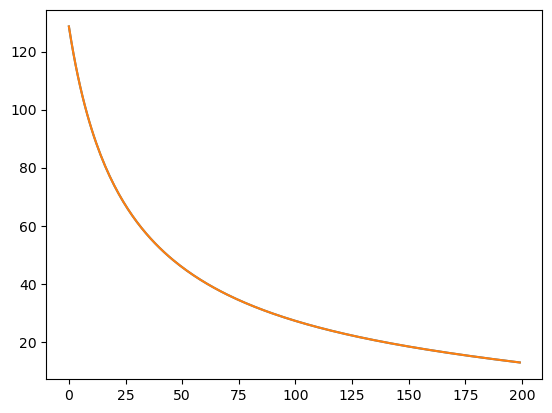

In [50]:
plt.plot(UA)
plt.plot(dfs["UA"])

In [53]:
def solve_sigma(sigma):
    rfi = hex.ri - sigma
    Ac1 = np.pi * rfi ** 2
    D1 = 2 * rfi
    Vol1 = fluid1.m / fluid1.rho
    v1 = Vol1 / Ac1
    Re = fluid1.get_Re(v1, D1)
    Cf = fluid1.get_Fricion(Re)
    return Cf  / D1 * fluid1.rho * v1 ** 2 / 2  - dp1 / hex.dx

guess_sigma = (1e-5) * np.ones(len(dfs))
sigma_sol = fsolve(solve_sigma, guess_sigma)

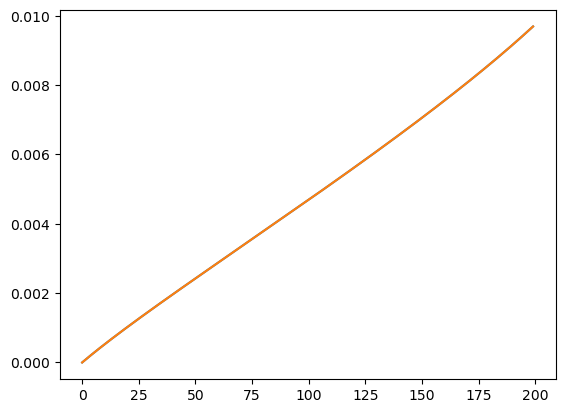

In [54]:
plt.plot(dfs["Sigma1"])
plt.plot(sigma_sol)

In [55]:
def solve_k():
    rfi = hex.ri - sigma_sol
    Ac1 = np.pi * rfi ** 2
    D1 = 2 * rfi
    As1 = np.pi * D1 * hex.dx
    Vol1 = fluid1.m / fluid1.rho
    v1 = Vol1 / Ac1
    Re = fluid1.get_Re(v1, D1)
    Pr = fluid1.get_Pr()
    Nu = fluid1.get_Nu(Re, Pr)
    h1 = fluid1.get_h(Nu, D1)
    
    num = np.log(hex.ri / rfi) / (2 * np.pi  * hex.dx)
    den = (Rflu - 1 / (As1 * h1))

    return num / den

k_sol = solve_k()

In [56]:
rfi = hex.ri - sigma_sol

In [64]:
type(rfi) == np.ndarray

True

In [60]:
D1 = 2 * rfi

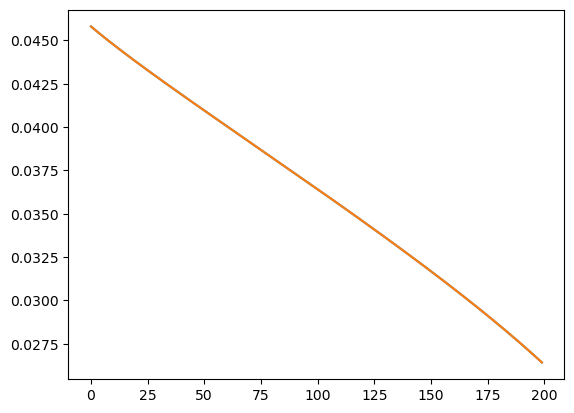

In [61]:
plt.plot(D1)
plt.plot(dfs["F1D"])

In [28]:
rfi = hex.ri - sigma_sol
Ac1 = np.pi * rfi ** 2
D1 = 2 * rfi
As1 = np.pi * D1 * hex.dx
Vol1 = fluid1.m / fluid1.rho
v1 = Vol1 / Ac1

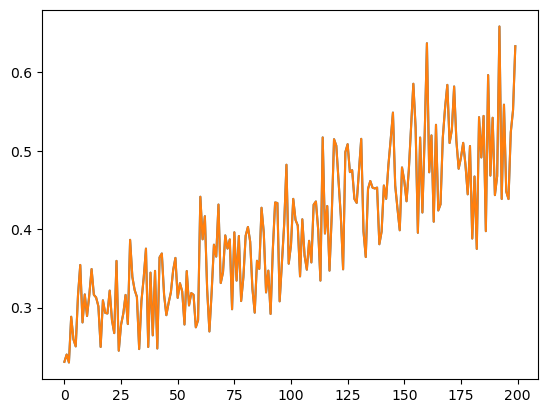

In [29]:
plt.plot(v1)
plt.plot(dfs["F1v"])

In [30]:
Re = fluid1.get_Re(v1, D1)
Pr = fluid1.get_Pr()
Nu = fluid1.get_Nu(Re, Pr)
h1 = fluid1.get_h(Nu, D1)

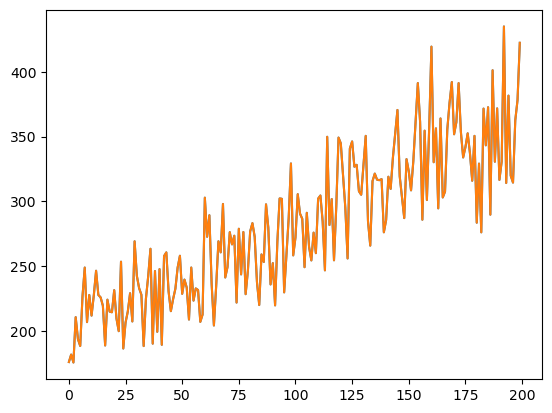

In [34]:
plt.plot(h1)
plt.plot(dfs["F1h"])

In [39]:
(Rflu - 1 / (As1 * h1)) * 2 * np.pi * hex.ri * hex.dx

0      2.667912e-14
1      3.202925e-04
2      5.249733e-04
3      8.451302e-04
4      9.702424e-04
           ...     
195    5.252662e-02
196    5.311776e-02
197    5.351862e-02
198    5.363557e-02
199    5.376880e-02
Length: 200, dtype: float64

In [43]:
Rflu / (2 * np.pi * hex.dx)

0      0.000169
1      0.000173
2      0.000186
3      0.000167
4      0.000184
         ...   
195    0.001691
196    0.001711
197    0.001705
198    0.001704
199    0.001697
Length: 200, dtype: float64

In [44]:
dfs["Rf1"] / (2 * np.pi * hex.ri * hex.L)

0      0.000000
1      0.000364
2      0.000595
3      0.000956
4      0.001096
         ...   
195    0.043031
196    0.043394
197    0.043640
198    0.043711
199    0.043792
Name: Rf1, Length: 200, dtype: float64

In [45]:
np.log(hex.ri / (hex.ri - sigma_sol)) / (2 * 0.2 * hex.dx * np.pi)

array([7.61276481e-13, 3.63906753e-04, 5.95401492e-04, 9.55864457e-04,
       1.09618985e-03, 1.48398144e-03, 1.92199023e-03, 2.10077016e-03,
       2.25007858e-03, 2.67784488e-03, 2.92210108e-03, 3.04886097e-03,
       3.40182022e-03, 3.56809256e-03, 3.86844519e-03, 4.03336766e-03,
       4.38644969e-03, 4.79049884e-03, 5.06241068e-03, 5.14025836e-03,
       5.31974955e-03, 5.70493979e-03, 5.86683064e-03, 6.26678591e-03,
       6.43249485e-03, 6.82260688e-03, 7.19255510e-03, 7.57226883e-03,
       7.73605371e-03, 7.99865042e-03, 8.09605144e-03, 8.22937366e-03,
       8.36911220e-03, 8.54498900e-03, 8.82787647e-03, 9.14563728e-03,
       9.23222601e-03, 9.33328383e-03, 9.64256863e-03, 9.85557621e-03,
       1.01629417e-02, 1.02777117e-02, 1.08575748e-02, 1.10082969e-02,
       1.11744920e-02, 1.15297273e-02, 1.17784198e-02, 1.20194768e-02,
       1.22715465e-02, 1.24573253e-02, 1.25271778e-02, 1.27993270e-02,
       1.30974638e-02, 1.34484881e-02, 1.37118684e-02, 1.38299718e-02,
      